In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
import addict
import datetime
import os
import pickle
import scipy
import colorcet as cc
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload

import skies


In [3]:
run_name = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
base_runs_folder = "./runs/"
output_path = os.path.join(base_runs_folder, run_name)
mesh_parameters_file_name = "western_north_america_mesh_parameters.json"
skies.create_output_folder(base_runs_folder, output_path)
meshes = skies.read_meshes(mesh_parameters_file_name)
skies.print_magnitude_overview(meshes)


output_path='./runs/2022_11_10_10_35_07'
Read: western_north_america_mesh_parameters.json



Warning: The file contains tag data that couldn't be processed.

Read: cascadia.msh
Magnitude overview:
Maximum moment magnitude of entire mesh = 10.61
Maximum moment magnitude of single mesh element = 6.90
Minimum moment magnitude of single mesh element = 5.52


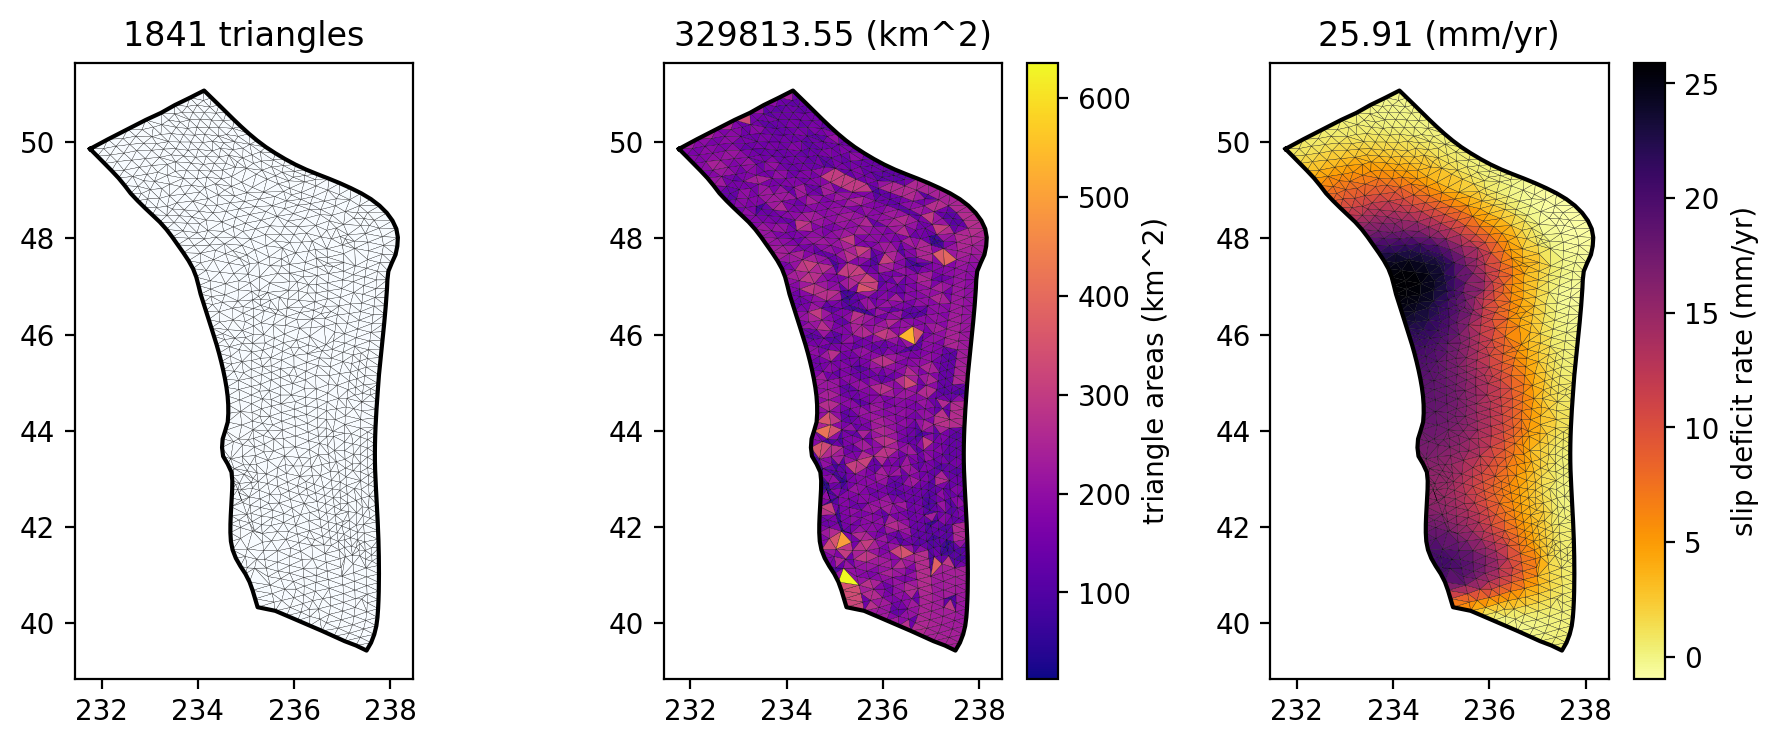

In [4]:
# Load initial slip defict and multiply by time cascadia_low_resolution_tde_dip_slip_rates.npy
mesh_initial_dip_slip_deficit = np.load("cascadia_low_resolution_tde_dip_slip_rates.npy")
skies.plot_initial_data(meshes, mesh_initial_dip_slip_deficit)


In [18]:
import matplotlib
import timeit
from scipy.interpolate import griddata

fontsize = 18
KM2_TO_M2 = 1e6


def plot_event_for_animation(
    event,
    meshes,
    pre_event_slip_deficit,
    probability,
    post_event_slip_deficit,
    last_event_slip,
    total_slip,
    t,
    iteration_step,
):
    """
    1. Slip deficit rate
    2. Current moment distribution
    3. Slip at current time step
    4. Last earthquake
    5. Total slip
    """

    plt.figure(figsize=(10, 4))

    # Plot spatially variable temporally constant slip deficit rate
    plt.subplot(1, 5, 1)
    fill_value = mesh_initial_dip_slip_deficit
    x_vec = np.linspace(
        params.min_longitude, params.max_longitude, params.n_grid_longitude
    )
    y_vec = np.linspace(
        params.min_latitude, params.max_latitude, params.n_grid_latitude
    )
    x_mat, y_mat = np.meshgrid(x_vec, y_vec)
    centroids_lon = meshes[0].centroids[:, 0]
    centroids_lat = meshes[0].centroids[:, 1]
    # centroids_val = fill_value
    fill_value_mat = griddata(
        (centroids_lon, centroids_lat), fill_value, (x_mat, y_mat), method="cubic"
    )
    # Set values outside of mesh polygon to nan so they don't plot
    inpolygon_vals = skies.inpolygon(
        x_mat, y_mat, meshes[0].x_perimeter, meshes[0].y_perimeter
    )
    inpolygon_vals = np.reshape(
        inpolygon_vals, (params.n_grid_longitude, params.n_grid_latitude)
    )
    fill_value_mat[~inpolygon_vals] = np.nan
    cmap = cc.cm.bmy_r
    levels = np.linspace(0, 30, 11)
    plt.contourf(x_mat, y_mat, fill_value_mat, cmap=cmap, levels=levels, extend="both")
    plt.contour(
        x_mat,
        y_mat,
        fill_value_mat,
        colors="k",
        linestyles="solid",
        linewidths=0.25,
        levels=levels,
        extend="both",
    )
    plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k", linewidth=1.0)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.gca().set_facecolor("gainsboro")
    plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k")
    plt.xticks([])
    plt.yticks([])
    plt.xlabel("$v_{sd}$", fontsize=fontsize)


    # Plot spatially variable pre event moment
    plt.subplot(1, 5, 2)
    fill_value = pre_event_slip_deficit
    x_vec = np.linspace(
        params.min_longitude, params.max_longitude, params.n_grid_longitude
    )
    y_vec = np.linspace(
        params.min_latitude, params.max_latitude, params.n_grid_latitude
    )
    x_mat, y_mat = np.meshgrid(x_vec, y_vec)
    centroids_lon = meshes[0].centroids[:, 0]
    centroids_lat = meshes[0].centroids[:, 1]
    # centroids_val = fill_value
    fill_value_mat = griddata(
        (centroids_lon, centroids_lat), fill_value, (x_mat, y_mat), method="cubic"
    )
    # Set values outside of mesh polygon to nan so they don't plot
    inpolygon_vals = skies.inpolygon(
        x_mat, y_mat, meshes[0].x_perimeter, meshes[0].y_perimeter
    )
    inpolygon_vals = np.reshape(
        inpolygon_vals, (params.n_grid_longitude, params.n_grid_latitude)
    )
    fill_value_mat[~inpolygon_vals] = np.nan
    cmap = cc.cm.CET_L19
    cmap = cc.cm.coolwarm
    levels = np.linspace(-5e9, 5e9, 11)
    plt.contourf(x_mat, y_mat, fill_value_mat, cmap=cmap, levels=levels, extend="both")
    plt.contour(
        x_mat,
        y_mat,
        fill_value_mat,
        colors="k",
        linestyles="solid",
        linewidths=0.25,
        levels=levels,
    )
    plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k", linewidth=1.0)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.gca().set_facecolor("gainsboro")
    plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k")
    plt.xticks([])
    plt.yticks([])
    plt.xlabel("$m$", fontsize=fontsize)



    # Plot coseismic slip distribution
    plt.subplot(1, 5, 3)
    fill_value = np.zeros(meshes[0].n_tde)
    fill_value[event.triangle_index] = event.slip
    x_vec = np.linspace(
        params.min_longitude, params.max_longitude, params.n_grid_longitude
    )
    y_vec = np.linspace(
        params.min_latitude, params.max_latitude, params.n_grid_latitude
    )
    x_mat, y_mat = np.meshgrid(x_vec, y_vec)
    centroids_lon = meshes[0].centroids[:, 0]
    centroids_lat = meshes[0].centroids[:, 1]
    centroids_val = fill_value
    fill_value_mat = griddata(
        (centroids_lon, centroids_lat), fill_value, (x_mat, y_mat), method="cubic"
    )
    # Set values outside of mesh polygon to nan so they don't plot
    inpolygon_vals = skies.inpolygon(
        x_mat, y_mat, meshes[0].x_perimeter, meshes[0].y_perimeter
    )
    inpolygon_vals = np.reshape(
        inpolygon_vals, (params.n_grid_longitude, params.n_grid_latitude)
    )
    fill_value_mat[~inpolygon_vals] = np.nan
    cmap = cc.cm.CET_L19
    levels = np.linspace(0.1, 10, 11)
    plt.contourf(x_mat, y_mat, fill_value_mat, cmap=cmap, levels=levels, extend="both")
    plt.contour(
        x_mat,
        y_mat,
        fill_value_mat,
        colors="k",
        linestyles="solid",
        linewidths=0.25,
        levels=levels,
    )
    plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k", linewidth=1.0)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.gca().set_facecolor("gainsboro")
    plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k")
    plt.xticks([])
    plt.yticks([])
    print(f"{event.moment_magnitude=}")
    print(f"{event.moment_magnitude != 0.0}")
    if event.moment_magnitude != 0.0:
        plt.xlabel(f"$M_W$={event.moment_magnitude[0]:0.2f}", fontsize=fontsize)




    # Plot most recent coseismic slip distribution
    plt.subplot(1, 5, 4)
    fill_value = np.zeros(meshes[0].n_tde)
    fill_value = last_event_slip
    x_vec = np.linspace(
        params.min_longitude, params.max_longitude, params.n_grid_longitude
    )
    y_vec = np.linspace(
        params.min_latitude, params.max_latitude, params.n_grid_latitude
    )
    x_mat, y_mat = np.meshgrid(x_vec, y_vec)
    centroids_lon = meshes[0].centroids[:, 0]
    centroids_lat = meshes[0].centroids[:, 1]
    centroids_val = fill_value
    fill_value_mat = griddata(
        (centroids_lon, centroids_lat), fill_value, (x_mat, y_mat), method="cubic"
    )
    # Set values outside of mesh polygon to nan so they don't plot
    inpolygon_vals = skies.inpolygon(
        x_mat, y_mat, meshes[0].x_perimeter, meshes[0].y_perimeter
    )
    inpolygon_vals = np.reshape(
        inpolygon_vals, (params.n_grid_longitude, params.n_grid_latitude)
    )
    fill_value_mat[~inpolygon_vals] = np.nan
    cmap = cc.cm.CET_L19
    levels = np.linspace(0.1, 10, 11)
    plt.contourf(x_mat, y_mat, fill_value_mat, cmap=cmap, levels=levels, extend="both")
    plt.contour(
        x_mat,
        y_mat,
        fill_value_mat,
        colors="k",
        linestyles="solid",
        linewidths=0.25,
        levels=levels,
    )
    plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k", linewidth=1.0)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.gca().set_facecolor("gainsboro")
    plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k")
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(f"event $t_j$", fontsize=fontsize)



    # Plot total coseismic slip distribution
    plt.subplot(1, 5, 5)
    fill_value = np.zeros(meshes[0].n_tde)
    fill_value = total_slip
    x_vec = np.linspace(
        params.min_longitude, params.max_longitude, params.n_grid_longitude
    )
    y_vec = np.linspace(
        params.min_latitude, params.max_latitude, params.n_grid_latitude
    )
    x_mat, y_mat = np.meshgrid(x_vec, y_vec)
    centroids_lon = meshes[0].centroids[:, 0]
    centroids_lat = meshes[0].centroids[:, 1]
    # centroids_val = fill_value
    fill_value_mat = griddata(
        (centroids_lon, centroids_lat), fill_value, (x_mat, y_mat), method="cubic"
    )
    # Set values outside of mesh polygon to nan so they don't plot
    inpolygon_vals = skies.inpolygon(
        x_mat, y_mat, meshes[0].x_perimeter, meshes[0].y_perimeter
    )
    inpolygon_vals = np.reshape(
        inpolygon_vals, (params.n_grid_longitude, params.n_grid_latitude)
    )
    fill_value_mat[~inpolygon_vals] = np.nan
    cmap = cc.cm.bmy_r
    levels = np.linspace(0.1, 10, 11)
    plt.contourf(x_mat, y_mat, fill_value_mat, cmap=cmap, levels=levels, extend="both")
    plt.contour(
        x_mat,
        y_mat,
        fill_value_mat,
        colors="k",
        linestyles="solid",
        linewidths=0.25,
        levels=levels,
    )
    plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k", linewidth=1.0)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.gca().set_facecolor("gainsboro")
    plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k")
    plt.xticks([])
    plt.yticks([])
    plt.xlabel("$\sum s$", fontsize=fontsize)

    plt.suptitle(f"$t$={iteration_step}", fontsize=fontsize)

    # Save figure to file
    base_file_name = f"{iteration_step:010d}"
    plt.savefig(base_file_name + ".png", dpi=500)
    plt.close("all")
    # plt.show()


/var/folders/pq/qqjshcd51vg5t9w5ws8wkmw00000gn/T/ipykernel_36246/2074690079.py:104: UserWarning: No contour levels were found within the data range.
  plt.contour(


event.moment_magnitude=nan
True


/var/folders/pq/qqjshcd51vg5t9w5ws8wkmw00000gn/T/ipykernel_36246/2074690079.py:151: UserWarning: No contour levels were found within the data range.
  plt.contour(


TypeError: 'float' object is not subscriptable

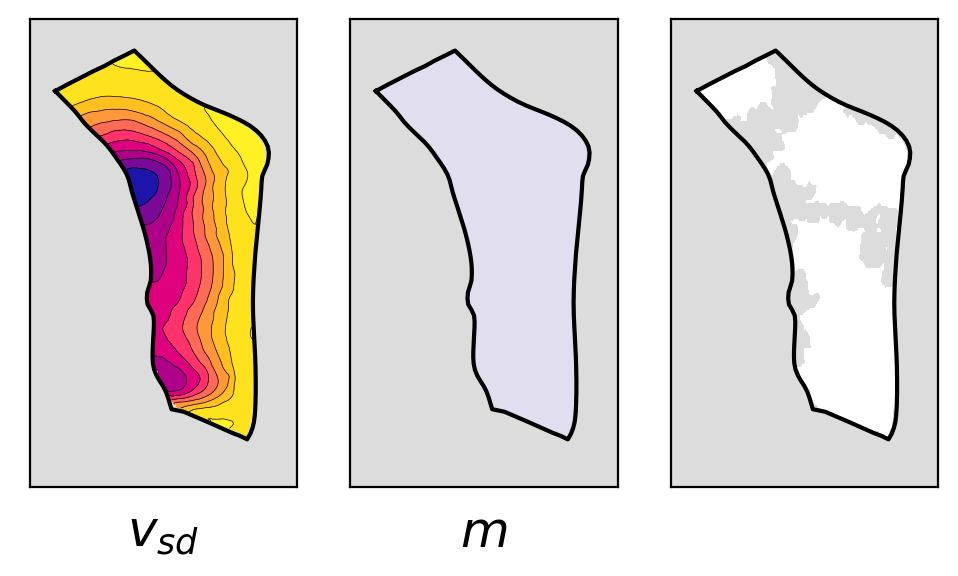

In [19]:
np.random.seed(2)


# Parameters for model run
params = addict.Dict()
params.n_time_steps = 600
params.time_step = 5e-7
params.b_value = -1.0
params.shear_modulus = 3e10
params.n_samples = 1
params.n_binary = 2
params.minimum_event_moment_magnitude = 7.0
params.maximum_event_moment_magnitude = 9.0
params.time_probability_amplitude_scale_factor = 5e-2
params.time_probability_data_scale_factor = 1e-12
params.area_scaling = 1.25
params.default_omori_decay_time = 100.0
params.minimum_probability = 1e-10
params.time_probability_history_scale_factor = 1e11
params.location_probability_amplitude_scale_factor = 1.0
params.location_probability_data_scale_factor = 1e-5
params.omori_amplitude_scale_factor = 3e-9
params.omori_rate_perturbation_scale_factor = 1e-1
params.mesh_index = 0
params.initial_mesh_slip_deficit_scaling = 0.0
params.geometic_moment_rate_scale_factor = 5e1
params.plot_events_in_loop = True
params.n_events_omori_history_effect = 100
params.n_grid_longitude = 200
params.n_grid_latitude = 200
params.min_longitude = 239.0
params.max_longitude = 231.0
params.min_latitude = 38.0
params.max_latitude = 52.0
params.n_contour_levels = 10
params.min_contour_value = 0.1  # (m)

# Select mesh if multiple have been loaded
mesh = meshes[params.mesh_index]

# Storage
time_series = addict.Dict()
time_series.time = np.linspace(0, params.n_time_steps, params.n_time_steps)
time_series.probability_weight = np.zeros_like(time_series.time)
time_series.probability = np.zeros_like(time_series.time)
time_series.event_magnitude = np.zeros_like(time_series.time)
time_series.event_trigger_flag = np.zeros_like(time_series.time)

# TODO: #22 Change earthquake to event. Make a dictionary?  Can I eliminate `earthquake_index_list`, `earthquake_magnitude_list`, `earthquake_probability_list`
earthquake_probability_list = []
time_series.omori_history_effect = np.zeros(
    (params.n_time_steps, params.n_events_omori_history_effect)
)

# Initial geometric moment and storage
# TODO: #23 Convert to mesh_geometric_moment dictionary?
mesh_geometric_moment = np.zeros(mesh.n_tde)
mesh_last_event_slip = np.zeros(mesh.n_tde)
mesh_total_slip = np.zeros(mesh.n_tde)
mesh_geometric_moment_pre_event = np.copy(mesh_geometric_moment)
mesh_geometric_moment_post_event = np.zeros_like(mesh_geometric_moment)
mesh_geometric_moment_scalar = np.zeros_like(time_series.time)
mesh_geometric_moment_scalar_non_zero = np.zeros_like(time_series.time)
mesh_geometric_moment_scalar[0] = np.sum(mesh_geometric_moment)

mesh_interseismic_loading_rate = (
    params.geometic_moment_rate_scale_factor * mesh_initial_dip_slip_deficit
)

# TODO: ADD LAST EQ SLIP
# TODO: ADD TOTAL EQ SLIP

# Main time loop
for i in range(params.n_time_steps - 1):
    # Determine whether there is an event at this time step
    time_series.probability_weight[i] = skies.get_tanh_probability(
        time_series.probability[i],
        params.time_probability_amplitude_scale_factor,
        params.time_probability_data_scale_factor,
    )
    time_series.event_trigger_flag[i] = np.random.choice(
        params.n_binary,
        params.n_samples,
        p=[1 - time_series.probability_weight[i], time_series.probability_weight[i]],
    )

    if bool(time_series.event_trigger_flag[i]):
        print(f"{i=}")
        event = addict.Dict()
        event.shear_modulus = np.array([params.shear_modulus])
        event.area_scaling = params.area_scaling
        event.moment_magnitude = skies.get_gutenberg_richter_magnitude(
            params.b_value,
            params.minimum_event_moment_magnitude,
            params.maximum_event_moment_magnitude,
        )
        event.moment = skies.moment_magnitude_to_moment(event.moment_magnitude)
        event.geometric_moment = event.moment / event.shear_modulus
        time_series.event_magnitude[i] = event.moment_magnitude[0]

        # Find event hypocentral triangle
        event.location_probability = skies.get_tanh_probability_vector(
            mesh_geometric_moment_pre_event,
            params.location_probability_amplitude_scale_factor,
            params.location_probability_data_scale_factor,
        )
        event.hypocenter_triangle_index = np.random.choice(
            mesh.n_tde, params.n_samples, p=event.location_probability
        )[0]

        # Generate coseismic slip area and slip distribution
        event = skies.get_event_area_slip_triangle_index(mesh, event)
        event.mesh_geometric_moment_pre_event = np.copy(mesh_geometric_moment_pre_event)
        event.mesh_geometric_moment_post_event = np.copy(
            mesh_geometric_moment_pre_event - (event.slip_all_elements * mesh.areas)
        )

        # Generate Omori rate decay
        event.omori_amplitude = params.omori_amplitude_scale_factor * event.geometric_moment_scalar
        event.omori_decay_time = params.default_omori_decay_time
        omori_rate_perturbation = skies.get_omori_decay_probability(
            time_series.time,
            time_series.time[i],
            event.omori_amplitude,
            decay_time=event.omori_decay_time,
        )

        # Coseismic offset to Omori rate effect
        omori_rate_perturbation[np.where(time_series.time > time_series.time[i])] -= (
            event.omori_amplitude * params.omori_rate_perturbation_scale_factor
        )

        # Store Omori rate decay
        earthquake_probability_list.append(omori_rate_perturbation)
        time_series.omori_history_effect[
            :, 0
        ] = omori_rate_perturbation  # Still need to implement below.

        # Update spatially variable mesh parameters
        mesh_geometric_moment -= event.slip_all_elements * mesh.areas
        mesh_last_event_slip = event.slip_all_elements
        mesh_total_slip += event.slip_all_elements

        # # Plot event
        # if params.plot_events_in_loop:
        #     plot_event_for_animation(
        #         event,
        #         meshes,
        #         event.mesh_geometric_moment_pre_event,
        #         event.location_probability,
        #         event.mesh_geometric_moment_post_event,
        #         mesh_last_event_slip,
        #         mesh_total_slip,
        #         i,
        #         i,
        #     )

    else:
        # Create dummy event dictionary because no event occured
        event = skies.create_non_event(mesh.n_tde)
        event.mesh_geometric_moment_pre_event = np.copy(mesh_geometric_moment_pre_event)
        event.mesh_geometric_moment_post_event = mesh_geometric_moment_pre_event + (
            params.time_step * mesh_interseismic_loading_rate * mesh.areas
        )

    # Plot event
    if params.plot_events_in_loop:
        plot_event_for_animation(
            event,
            meshes,
            event.mesh_geometric_moment_pre_event,
            event.location_probability,
            event.mesh_geometric_moment_post_event,
            mesh_last_event_slip,
            mesh_total_slip,
            i,
            i,
        )

    # Save event dictionary as pickle file
    event_pickle_file_name = f"{output_path}/event_{i:010.0f}.pickle"
    with open(event_pickle_file_name, "wb") as pickle_file:
        pickle.dump(event, pickle_file, protocol=pickle.HIGHEST_PROTOCOL)

    # Update mesh_geometric_moment
    mesh_geometric_moment += (
        params.time_step * mesh_interseismic_loading_rate * mesh.areas
    )
    mesh_geometric_moment_scalar[i + 1] = np.sum(mesh_geometric_moment)
    mesh_geometric_moment_scalar_non_zero[i + 1] = np.sum(
        mesh_geometric_moment[np.where(mesh_geometric_moment > 0.0)]
    )

    # Pre-event moment for next time step
    mesh_geometric_moment_pre_event = np.copy(mesh_geometric_moment)

    # Update probability
    time_series.probability[i + 1] = mesh_geometric_moment_scalar_non_zero[i + 1]

    # Sum contribution from all past earthquakes
    for j in range(len(earthquake_probability_list)):
        time_series.probability[i + 1] += (
            params.time_probability_history_scale_factor
            * earthquake_probability_list[j][i + 1]
        )


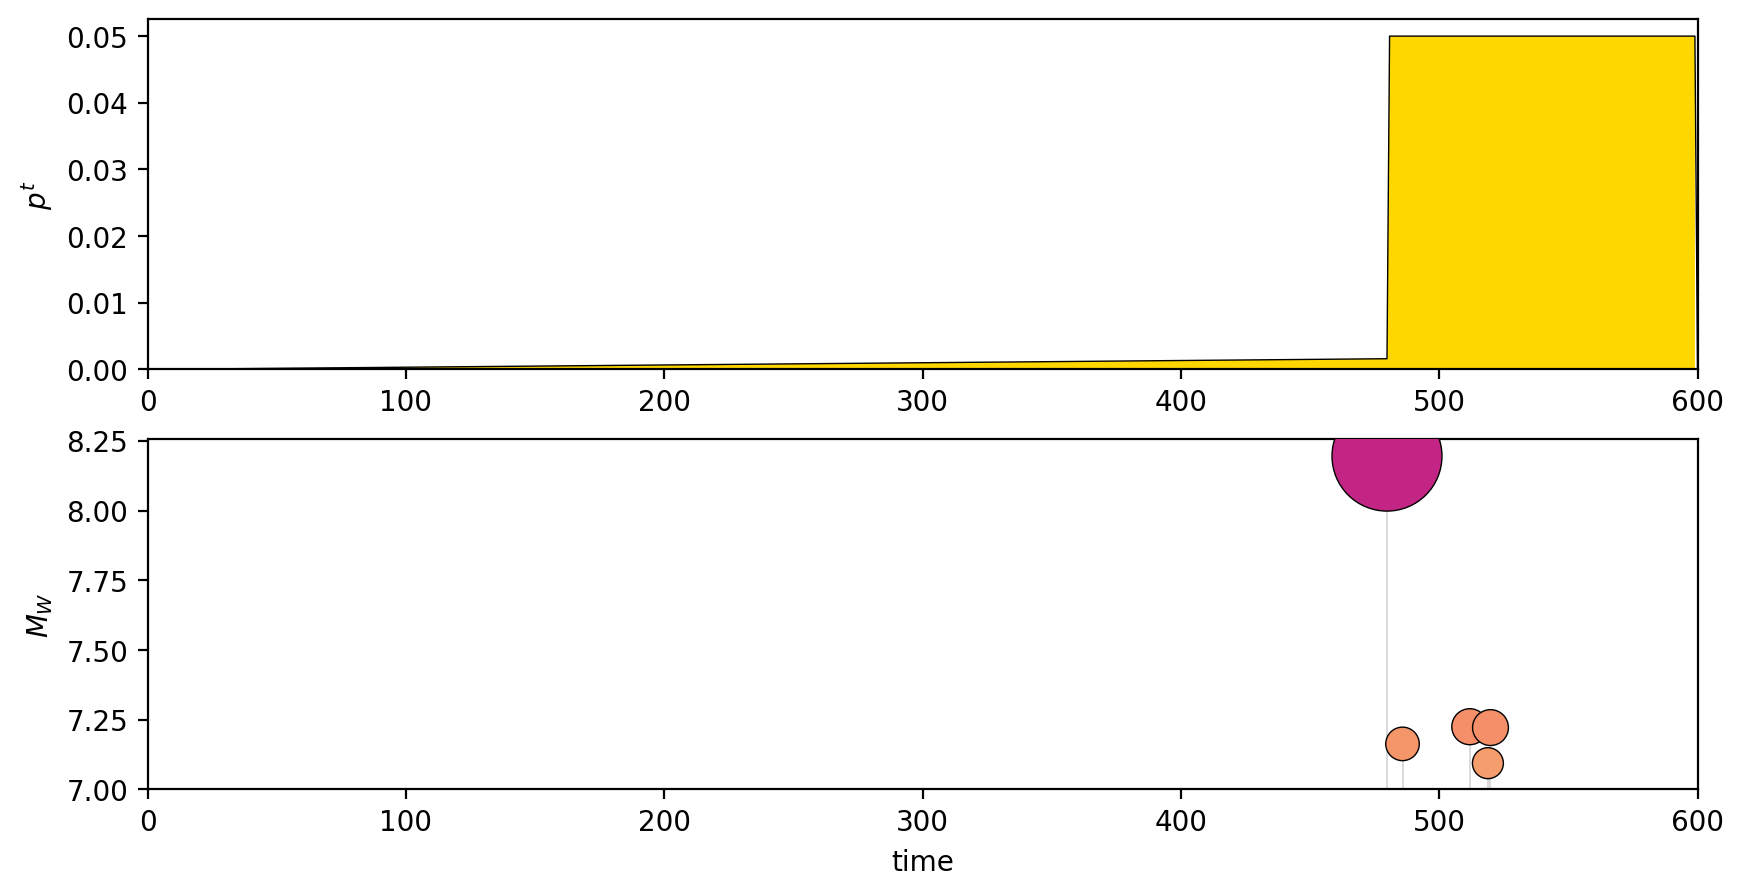

In [7]:
def plot_probability_and_events_time_series(
    time_series,
    start_idx,
    end_idx,
):
    event_idx = np.where(time_series.event_trigger_flag == 1)[0]
    figsize = (10, 5)
    plt.figure(figsize=figsize)

    # Plot probability time series
    plt.subplot(2, 1, 1)
    plt.plot(
        time_series.time[start_idx:end_idx],
        time_series.probability_weight[start_idx:end_idx],
        "-k",
        linewidth=0.5,
    )
    plt.plot(
        [time_series.time[start_idx], time_series.time[end_idx - 1]],
        [0, 0],
        "-k",
        linewidth=0.5,
    )
    plt.fill_between(
        time_series.time[start_idx:end_idx],
        time_series.probability_weight[start_idx:end_idx],
        np.zeros_like(time_series.time[start_idx:end_idx]),
        time_series.probability_weight[start_idx:end_idx] > 0,
        color="gold",
        alpha=1.0,
        edgecolor=None,
    )

    plt.fill_between(
        time_series.time[start_idx:end_idx],
        time_series.probability_weight[start_idx:end_idx],
        np.zeros_like(time_series.time[start_idx:end_idx]),
        time_series.probability_weight[start_idx:end_idx] < 0,
        color="dodgerblue",
        alpha=1.0,
        edgecolor=None,
    )
    plt.xlim([start_idx, end_idx])
    plt.gca().set_ylim(bottom=0.0)
    plt.ylabel("$p^t$")

    # Plot earthquake magnitude stem plot
    plt.subplot(2, 1, 2)
    for i in range(event_idx.size):
        plt.plot(
            [
                time_series.time[event_idx[i]],
                time_series.time[event_idx[i]],
            ],
            [
                params.minimum_event_moment_magnitude,
                time_series.event_magnitude[event_idx[i]],
            ],
            "-",
            linewidth=0.1,
            zorder=10,
            color="k",
        )

    cmap = cc.cm.CET_L17
    magnitude_plot_size = 1e-5 * 10 ** time_series.event_magnitude[event_idx]
    plt.scatter(
        time_series.time[event_idx],
        time_series.event_magnitude[event_idx],
        s=magnitude_plot_size,
        c=time_series.event_magnitude[event_idx],
        zorder=20,
        alpha=1.0,
        edgecolors="k",
        linewidths=0.5,
        cmap=cmap,
        vmin=6.0,
        vmax=9.0,
    )

    plt.xlabel("time")
    plt.ylabel("$M_W$")
    plt.xlim([start_idx, end_idx])
    plt.gca().set_ylim(bottom=params.minimum_event_moment_magnitude)
    plt.show()


start_idx = 0
end_idx = time_series.time.size
plot_probability_and_events_time_series(
    time_series,
    start_idx,
    end_idx,
)


In [8]:
# TODO: #25 Calculate mean time between earthquakes at different magnitudes
# TODO: #26 Add background random seismicity component

In [9]:
# np.roll example of rotating an array by rows
a = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
print(np.roll(a, 1, 0))

[[7 8 9]
 [1 2 3]
 [4 5 6]]


interp2d elapsed time: 0.5325036670546979
inpolygon elapsed time: 0.01639991602860391



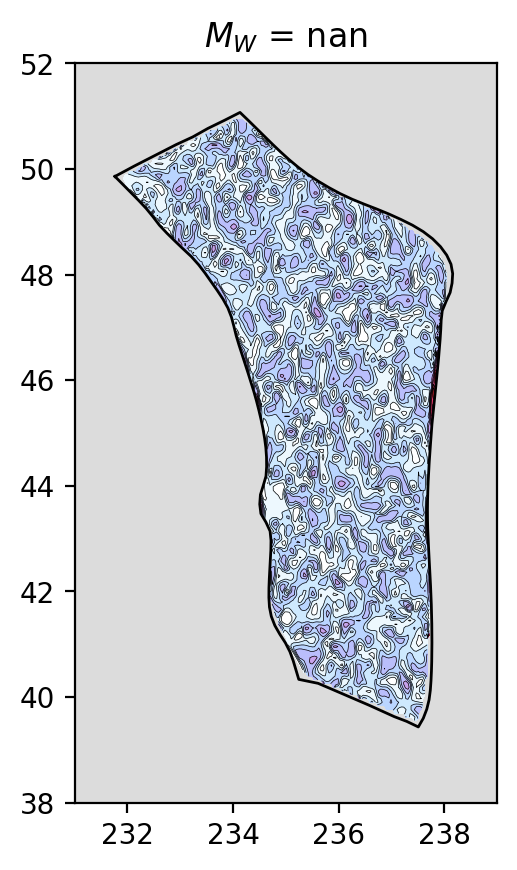

In [10]:
# Inpolygon speed tests based on information from:
# https://stackoverflow.com/questions/36399381/whats-the-fastest-way-of-checking-if-a-point-is-inside-a-polygon-in-python

# Classic skies

# Can we do better?  Some references:
# https://plotly.com/python/v3/interpolation-and-extrapolation-in-2d/
# https://github.com/GlacioHack/xdem/pull/165
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp2d.html#scipy.interpolate.interp2d

# Nearest neighbor griddata
import timeit
fill_value = event.slip_all_elements
fill_value = np.random.rand(event.slip_all_elements.size)
x_vec = np.linspace(params.min_longitude, params.max_longitude, params.n_grid_longitude)
y_vec = np.linspace(params.min_latitude, params.max_latitude, params.n_grid_latitude)
x_mat, y_mat = np.meshgrid(x_vec, y_vec)
centroids_lon = meshes[0].centroids[:, 0]
centroids_lat = meshes[0].centroids[:, 1]
centroids_val = fill_value

from scipy.interpolate import griddata

start_time = timeit.default_timer()
fill_value_mat = griddata(
    (centroids_lon, centroids_lat), fill_value, (x_mat, y_mat), method="cubic"
)
print(f"interp2d elapsed time: {timeit.default_timer() - start_time}")


# Select only values inside of mesh polygon
start_time = timeit.default_timer()
inpolygon_vals = skies.inpolygon(
    x_mat, y_mat, meshes[0].x_perimeter, meshes[0].y_perimeter
)
inpolygon_vals = np.reshape(
    inpolygon_vals, (params.n_grid_longitude, params.n_grid_latitude)
)
fill_value_mat[~inpolygon_vals] = np.nan
print(f"inpolygon elapsed time: {timeit.default_timer() - start_time}")
print()


# Plot
cmap = cc.cm.CET_L19
levels = np.linspace(
    params.min_contour_value, np.nanmax(fill_value_mat), params.n_contour_levels
)
plt.contourf(x_mat, y_mat, fill_value_mat, cmap=cmap, levels=levels, extend="both")
# cb = plt.colorbar(cax=plt.gca().inset_axes((0.03, 0.60, 0.02, 0.35)), label="slip (m)")
plt.contour(
    x_mat,
    y_mat,
    fill_value_mat,
    colors="k",
    linestyles="solid",
    linewidths=0.25,
    levels=levels,
)
plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k", linewidth=1.0)
plt.gca().set_aspect("equal", adjustable="box")
plt.gca().set_facecolor("gainsboro")
plt.title(f"$M_W$ = {event.moment_magnitude:0.3}")
plt.show()


In [11]:
f"{i:010d}"

'0000000598'